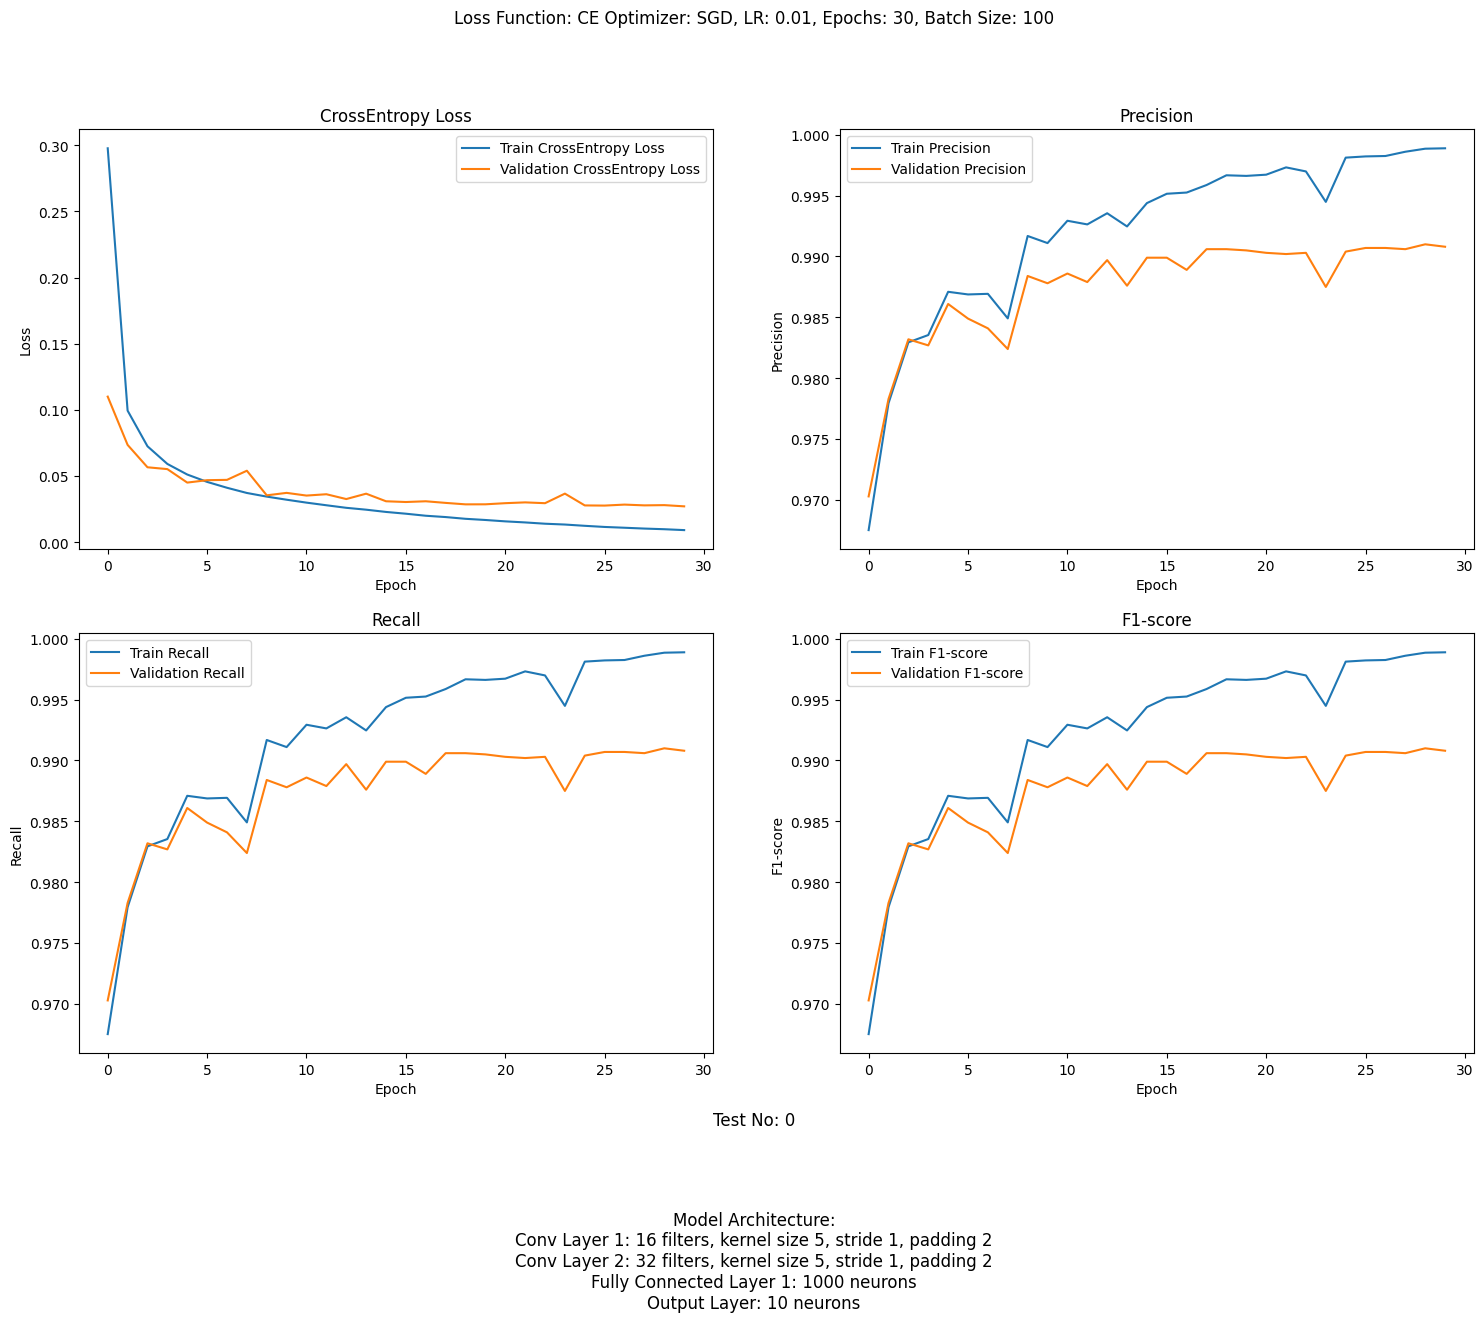

NameError: name 'val_accuracy' is not defined

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize
from IPython.display import clear_output
import numpy as np
import os

# Установка параметров
num_classes = 10
num_epochs = 30
batch_size = 100
learning_rate = 0.01
save_model = True
log_file_path = 'results/ResultsLog.log'

# Загрузка и нормализация данных MNIST
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Определение модели
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7*7*32, 1000)
        self.fc2 = nn.Linear(1000, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet(num_classes)

# Инициализация функции потерь
criterion_ce = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Инициализация для графиков
loss_ce_list = {'train': [], 'val': []}
precision_list = {'train': [], 'val': []}
recall_list = {'train': [], 'val': []}
f1_list = {'train': [], 'val': []}

# Проверка существования файла логирования и создание нового
if not os.path.exists(log_file_path):
    with open(log_file_path, 'w') as log_file:
        log_file.write("Test No\tPrecision\tRecall\tF1-score\n")

# Функция для вычисления метрик
def compute_metrics(loader, model):
    all_labels = []
    all_predicted = []
    all_probs = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predicted.extend(predicted.numpy())
            all_probs.extend(outputs.numpy())
    
    precision = precision_score(all_labels, all_predicted, average='micro')
    recall = recall_score(all_labels, all_predicted, average='micro')
    f1 = f1_score(all_labels, all_predicted, average='micro')
    
    return precision, recall, f1

# Функция для обновления и сохранения графиков
def update_plots(loss_ce_list, precision_list, recall_list, f1_list, epoch, save_path='../temp/training_progress.png'):
    clear_output(wait=True)
    plt.figure(figsize=(18, 12))
    
    # График функции потерь CrossEntropy
    plt.subplot(2, 2, 1)
    plt.plot(loss_ce_list['train'], label='Train CrossEntropy Loss')
    plt.plot(loss_ce_list['val'], label='Validation CrossEntropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CrossEntropy Loss')
    plt.legend()

    # График Precision
    plt.subplot(2, 2, 2)
    plt.plot(precision_list['train'], label='Train Precision')
    plt.plot(precision_list['val'], label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.legend()

    # График Recall
    plt.subplot(2, 2, 3)
    plt.plot(recall_list['train'], label='Train Recall')
    plt.plot(recall_list['val'], label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.legend()

    # График F1-score
    plt.subplot(2, 2, 4)
    plt.plot(f1_list['train'], label='Train F1-score')
    plt.plot(f1_list['val'], label='Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('F1-score')
    plt.legend()
    
    # Номер теста
    plt.figtext(0.5, 0.05, f'Test No: {get_test_number(log_file_path)}', wrap=True, horizontalalignment='center', fontsize=12)

    # Добавление информации о модели
    plt.suptitle(f'Loss Function: CE Optimizer: SGD, LR: {learning_rate}, Epochs: {num_epochs}, Batch Size: {batch_size}')
    
    # Информация о слоях модели
    model_info = (
        f"Model Architecture:\n"
        f"Conv Layer 1: 16 filters, kernel size 5, stride 1, padding 2\n"
        f"Conv Layer 2: 32 filters, kernel size 5, stride 1, padding 2\n"
        f"Fully Connected Layer 1: 1000 neurons\n"
        f"Output Layer: {num_classes} neurons"
    )
    
    plt.figtext(0.5, -0.1, model_info, wrap=True, horizontalalignment='center', fontsize=12)
    
    # Сохранение графиков в файл
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Функция для получения номера теста
def get_test_number(log_file_path):
    with open(log_file_path, 'r') as log_file:
        lines = log_file.readlines()
        return len(lines) - 1  # Исключаем заголовок

# Функция для сохранения модели
def save_model(model, test_number):
    model_path = f'models/model_{test_number}.ckpt'
    torch.save(model.state_dict(), model_path)
    return model_path

# Обучение модели
total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss_ce = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(images)
        
        # Преобразование данных для функции потерь
        labels_ce = labels
        
        loss_ce = criterion_ce(outputs, labels_ce)

        optimizer.zero_grad()
        loss_ce.backward()
        optimizer.step()
        
        running_loss_ce += loss_ce.item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss CE: {loss_ce.item():.4f}, ')
    
    # Тестирование модели
    model.eval()
    
    # Метрики для обучающего набора данных
    train_precision, train_recall, train_f1 = compute_metrics(train_loader, model)
    # Метрики для валидационного набора данных
    val_precision, val_recall, val_f1 = compute_metrics(test_loader, model)
    
    avg_loss_ce = running_loss_ce / total_step
    
    loss_ce_list['train'].append(avg_loss_ce)
    precision_list['train'].append(train_precision)
    recall_list['train'].append(train_recall)
    f1_list['train'].append(train_f1)

    # Тестовая функция потерь
    val_loss_ce = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            val_loss_ce += criterion_ce(outputs, labels).item()
    val_loss_ce /= len(test_loader)
    loss_ce_list['val'].append(val_loss_ce)
    
    precision_list['val'].append(val_precision)
    recall_list['val'].append(val_recall)
    f1_list['val'].append(val_f1)

    # Обновление и сохранение графиков
    update_plots(loss_ce_list, precision_list, recall_list, f1_list, epoch)

    model.train()

# Запись результатов тестов в файл логирования
with open(log_file_path, 'a') as log_file:
    log_file.write(f"{get_test_number(log_file_path)}\t{val_accuracy:.4f}\t{val_precision:.4f}\t{val_recall:.4f}\t{val_f1:.4f}\t{val_roc_auc:.4f}\n")



# Сохранение финальных графиков
update_plots(loss_ce_list, accuracy_list, precision_list, recall_list, f1_list, roc_auc_list, num_epochs-1, f'results/test_{get_test_number(log_file_path)}.png')


# Функция для сохранения модели
def save_model(model, test_number):
    model_path = f'models/model_{test_number}.ckpt'
    torch.save(model.state_dict(), model_path)
    return model_path

if save_model:
    test_number = get_test_number(log_file_path)
    model_path = save_model(model, test_number)
    print(f"Model saved as {model_path}")


